In [339]:
%load_ext autoreload
%autoreload 1
%aimport src
%aimport src.utils
%aimport src.SdmIsmAnalysis
%aimport src.SimpleSynthesis

# display last assigned variable automatically
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

%matplotlib inline
from matplotlib.pyplot import *

from src.utils import mygrid

import seaborn as sns
import polars as pl
import numpy as np
import scipy
from pathlib import Path
import os

from src.SimpleSynthesis import SimpleSynthesis

import pyfar as pf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Order the existing samples randomly but with training at first position (index 2):

In [236]:
good_ones_raw = pl.read_parquet("listening_test_good_ones.parquet").with_row_index()
with pl.Config(tbl_rows=100):
    display(good_ones)

index,to_listener,to_source,room,from_listener,from_source,error_score
u32,str,i32,str,str,i32,f64
7,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,0.454629
0,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",1,0.721165
9,"""1.75X_-2.0Y""",2,"""HL05W""","""1.75X_-2.0Y""",0,0.397234
2,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",0,0.775207
12,"""1.75X_-2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",0,0.642112
4,"""3.0X_2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,0.636626
17,"""-1.75X_-3.0Y""",4,"""HL06W""","""3.0X_2.0Y""",4,0.512177
5,"""-1.25X_0.0Y""",0,"""HL06W""","""1.75X_-2.0Y""",1,1.178172
10,"""-1.75X_-3.0Y""",4,"""HL05W""","""3.0X_2.0Y""",0,0.429625


Have the two training examples at index 0 and 1, then the others randomly:

In [237]:
training0_idx = good_ones_raw.filter(
    pl.col("room").eq("HL05W") & pl.col("to_listener").eq("0.0X_0.0Y") & pl.col("to_source").eq(1)
)["index"][0]

7

In [238]:
training1_idx = good_ones_raw.filter(
    pl.col("room").eq("HL06W") & pl.col("to_listener").eq("3.0X_2.0Y") & pl.col("to_source").eq(4)
)["index"][0]

0

In [239]:
np.random.seed(497273)
order_permutation = np.concatenate(([training0_idx, training1_idx], np.random.permutation([i for i in range(20) if i not in [training0_idx, training1_idx]])))

array([ 7,  0,  9,  2, 12,  4, 17,  5, 10, 18,  8,  3,  1, 15, 14, 19,  6,
       13, 11, 16])

In [240]:
assert np.unique(order_permutation).size == good_ones_raw.shape[0]

In [243]:
good_ones = good_ones_raw[order_permutation].drop("index").with_row_index()

index,to_listener,to_source,room,from_listener,from_source,error_score
u32,str,i32,str,str,i32,f64
0,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,0.454629
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",1,0.721165
2,"""1.75X_-2.0Y""",2,"""HL05W""","""1.75X_-2.0Y""",0,0.397234
3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",0,0.775207
4,"""1.75X_-2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",0,0.642112
…,…,…,…,…,…,…
15,"""-1.25X_0.0Y""",3,"""HL06W""","""3.0X_2.0Y""",0,0.864433
16,"""1.75X_-2.0Y""",2,"""HL06W""","""3.0X_2.0Y""",0,1.0148
17,"""3.0X_2.0Y""",3,"""HL05W""","""0.0X_0.0Y""",3,0.652367


In [244]:
bad_ones = pl.read_parquet("listening_test_bad_ones.parquet")
with pl.Config(tbl_rows=100):
    display(bad_ones)

to_listener,to_source,room,from_listener,from_source,error_score
str,i32,str,str,i32,f64
"""3.0X_2.0Y""",1,"""HL06W""","""1.75X_-2.0Y""",3,2.235143
"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",3,1.754721
"""3.0X_2.0Y""",3,"""HL06W""","""3.0X_2.0Y""",4,1.447027
"""3.0X_2.0Y""",3,"""HL05W""","""1.75X_-2.0Y""",4,1.229486
"""1.75X_-2.0Y""",0,"""HL05W""","""3.0X_2.0Y""",2,1.560093
"""-1.25X_0.0Y""",3,"""HL05W""","""3.0X_2.0Y""",0,1.019636
"""-1.25X_0.0Y""",4,"""HL06W""","""1.75X_-2.0Y""",3,1.470415
"""1.75X_-2.0Y""",1,"""HL06W""","""1.75X_-2.0Y""",3,1.348235
"""3.0X_2.0Y""",1,"""HL05W""","""3.0X_2.0Y""",3,1.251613


In [245]:
df0 = good_ones.select(
    "index", "to_listener", "to_source", "room",
    pl.col("from_listener").alias("from_listener_good"),
    pl.col("from_source").alias("from_source_good"),
).join(
    bad_ones.select(
        "to_listener", "to_source", "room",
        pl.col("from_listener").alias("from_listener_bad"),
        pl.col("from_source").alias("from_source_bad"),
    ),
    ["room", "to_listener", "to_source", ],
).sort("index")
with pl.Config(tbl_rows=100):
    display(df0)

index,to_listener,to_source,room,from_listener_good,from_source_good,from_listener_bad,from_source_bad
u32,str,i32,str,str,i32,str,i32
0,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",1
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",1,"""3.0X_2.0Y""",3
2,"""1.75X_-2.0Y""",2,"""HL05W""","""1.75X_-2.0Y""",0,"""3.0X_2.0Y""",1
3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",0,"""3.0X_2.0Y""",3
4,"""1.75X_-2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",0,"""3.0X_2.0Y""",3
5,"""3.0X_2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",3
6,"""-1.75X_-3.0Y""",4,"""HL06W""","""3.0X_2.0Y""",4,"""0.0X_0.0Y""",2
7,"""-1.25X_0.0Y""",0,"""HL06W""","""1.75X_-2.0Y""",1,"""-1.75X_-3.0Y""",1
8,"""-1.75X_-3.0Y""",4,"""HL05W""","""3.0X_2.0Y""",0,"""0.0X_0.0Y""",3


# Join in Azimuths

In [246]:
listenting_test_azimuths = np.array([ # determined approximately by hand
    -60,
    -30,
    90,
    -120,
    -60,
    0,
    -90, # adjusted from -90
    120,
    60,
    0,
    -150
])

listening_test_positions = np.array([
    "-1.25X_0.0Y_3SRC", # used to be "3.0X_2.0Y_0SRC" and ">0.0X_0.0Y_3SRC", but T30 not available
    "1.75X_-2.0Y_2SRC",
    "-1.75X_-3.0Y_4SRC",
    "3.0X_2.0Y_1SRC",
    "-1.25X_0.0Y_4SRC",
    "-1.25X_0.0Y_0SRC",
    "3.0X_2.0Y_3SRC",
    "1.75X_-2.0Y_0SRC",
    "1.75X_-2.0Y_1SRC", # used to be what training is
    "0.0X_0.0Y_1SRC", # training, T30 only in HL05W valid
    "3.0X_2.0Y_4SRC", #training, pick only from HL06W
])

original_az = pl.DataFrame({"az":np.arange(-180, 180, 30)}).with_row_index("az_idx")

az_idx,az
u32,i32
0,-180
1,-150
2,-120
3,-90
4,-60
…,…
7,30
8,60
9,90


In [247]:
az_df = pl.DataFrame({
    "az":listenting_test_azimuths, 
    "to":listening_test_positions
}).join(original_az, "az")

az,to,az_idx
i32,str,u32
-150,"""3.0X_2.0Y_4SRC…",1
-120,"""3.0X_2.0Y_1SRC…",2
-90,"""3.0X_2.0Y_3SRC…",3
-60,"""-1.25X_0.0Y_3S…",4
-60,"""-1.25X_0.0Y_4S…",4
…,…,…
0,"""-1.25X_0.0Y_0S…",6
0,"""0.0X_0.0Y_1SRC…",6
60,"""1.75X_-2.0Y_1S…",8


In [248]:
df = df0.with_columns(
    to = pl.concat_str([
        pl.col("to_listener"),
        pl.lit("_"),
        pl.col("to_source"),
        pl.lit("SRC")
    ])
).join(
    az_df, 
    "to"
).select(pl.exclude(
    "to"
))
with pl.Config(tbl_rows=100):
    display(df)

index,to_listener,to_source,room,from_listener_good,from_source_good,from_listener_bad,from_source_bad,az,az_idx
u32,str,i32,str,str,i32,str,i32,i32,u32
0,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",1,0,6
1,"""3.0X_2.0Y""",4,"""HL06W""","""3.0X_2.0Y""",1,"""3.0X_2.0Y""",3,-150,1
2,"""1.75X_-2.0Y""",2,"""HL05W""","""1.75X_-2.0Y""",0,"""3.0X_2.0Y""",1,-30,5
3,"""1.75X_-2.0Y""",0,"""HL06W""","""3.0X_2.0Y""",0,"""3.0X_2.0Y""",3,120,10
4,"""1.75X_-2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",0,"""3.0X_2.0Y""",3,60,8
5,"""3.0X_2.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",3,-120,2
6,"""-1.75X_-3.0Y""",4,"""HL06W""","""3.0X_2.0Y""",4,"""0.0X_0.0Y""",2,90,9
7,"""-1.25X_0.0Y""",0,"""HL06W""","""1.75X_-2.0Y""",1,"""-1.75X_-3.0Y""",1,0,6
8,"""-1.75X_-3.0Y""",4,"""HL05W""","""3.0X_2.0Y""",0,"""0.0X_0.0Y""",3,90,9


# Render BRIRs

In [249]:
main_path = Path("../data/processed/analysis_e10_full_run2")

a = (
    SimpleSynthesis()
    .read_HRTFs(
        "../data/processed/RWTH-2020-11307/Kemar_HRTF_sofa-onax_normalized.sofa"
    )
    .read_source_fr("../data/external/RL906-spatial-FR.sofa")
)

b = (
    SimpleSynthesis()
    .read_HRTFs(
        "../data/processed/RWTH-2020-11307/Kemar_HRTF_sofa-onax_normalized.sofa"
    )
    .read_source_fr("../data/external/RL906-spatial-FR.sofa")
)

SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription


C:\Users\jcmfs\Documents\MA\e4-vis-dataset\.venv\Lib\site-packages\pyfar\classes\coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((


SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription


In [300]:
arr = []
for row in df.iter_rows(named=True):
    to_name = f'{row["room"]}_{row["to_listener"]}_{row["to_source"]}SRC'
    print(f'{row["index"]} {to_name}')
    
    # reference and non-extrapolating
    a.read_input_sofas(main_path / to_name)
    reference_brir = a.reference_brirs[row["az_idx"], :]
    nonextrapolating_brir = a.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position,
        only_brir_indices=[row["az_idx"]]
    )[row["az_idx"], :]

    # lower anchor
    low_anchor_brir = reference_brir.copy()
    low_anchor_brir.time *= 0 # zero lower_anchor
    # 1000: direct sound position, 192: half HRTF
    low_anchor_brir.time[:, 1192] = np.sqrt(np.sum(pf.dsp.energy(reference_brir)))

    # good extrapolation
    from_name = f'{row["room"]}_{row["from_listener_good"]}_{row["from_source_good"]}SRC'
    print(f'{row["index"]} {from_name}')
    b.read_input_sofas(main_path / from_name)
    good_extrapolation = b.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position,
        only_brir_indices=[row["az_idx"]]
    )[row["az_idx"], :]
    
    # mid anchor: good one, only DS extrapolated, rest as if not extrapolating
    mid_anchor = b.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position, 
        imsrcs_make_unextrapolated=list(range(1, len(b.ism_histories))), # all except 0 (direct sound)
        only_brir_indices=[row["az_idx"]] 
    )[row["az_idx"], :]

    assert np.sum(pf.dsp.energy(mid_anchor - good_extrapolation)) > 0 # Just one of those sanity checks that were broken once

    # good extrapolation with exclusion
    good_runs = pl.read_parquet(main_path / from_name / "runs.parquet").with_row_index()
    good_filtered_imsrcs = good_runs.filter(pl.col("filter_energy") >= 5.5)["index"].to_list()
    print(f"filtered runs from good: {good_filtered_imsrcs} | src: {good_runs[good_filtered_imsrcs]['src'].to_list()}")
    good_filtered = b.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position, 
        imsrcs_make_unextrapolated=good_filtered_imsrcs,
        only_brir_indices=[row["az_idx"]] 
    )[row["az_idx"], :]

    # bad extrapolation
    from_name = f'{row["room"]}_{row["from_listener_bad"]}_{row["from_source_bad"]}SRC'
    print(f'{row["index"]} {from_name}')
    b.read_input_sofas(main_path / from_name)
    bad_extrapolation = b.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position,
        only_brir_indices=[row["az_idx"]]
    )[row["az_idx"], :]

    # bad extrapolation with exclusion
    bad_runs = pl.read_parquet(main_path / from_name / "runs.parquet").with_row_index()
    bad_filtered_imsrcs = bad_runs.filter(pl.col("filter_energy") >= 5.5)["index"].to_list()
    print(f"filtered runs from bad: {bad_filtered_imsrcs} | src: {bad_runs[bad_filtered_imsrcs]['src'].to_list()}")
    bad_filtered = b.extrapolating_synthesis(
        a.source_position, 
        a.source_orientation, 
        a.listener_position, 
        imsrcs_make_unextrapolated=bad_filtered_imsrcs,
        only_brir_indices=[row["az_idx"]] 
    )[row["az_idx"], :]
    
    arr.append({
        "reference": reference_brir,
        "nonextrapolating": nonextrapolating_brir,
        "lower_anchor": low_anchor_brir,
        "good": good_extrapolation,
        "mid_anchor": mid_anchor,
        "good_filtered": good_filtered,
        "bad": bad_extrapolation,
        "bad_filtered": bad_filtered,
    })

0 HL05W_0.0X_0.0Y_1SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound


C:\Users\jcmfs\Documents\MA\e4-vis-dataset\.venv\Lib\site-packages\pyfar\classes\coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((


0 HL05W_1.75X_-2.0Y_1SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound
filtered runs from good: [6, 7] | src: [16, 17]
0 HL05W_3.0X_2.0Y_1SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound
filtered runs from bad: [18] | src: [99]
1 HL06W_3.0X_2.0Y_4SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound
1 HL06W_3.0X_2.0Y_1SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription, GLOBAL_ReflectionHistories, PlaneNormals, PlaneDistances, SpeedOfSound
filtered runs from good: [5] | src: [18]
1 HL06W_3.0X_2.0Y_3SRC
SOFA file contained custom entries
----------------------------------
GLOBAL_RoomDescription,

In [326]:
brirs_df = pl.DataFrame(arr);
reference_energies = [np.mean(pf.dsp.energy(b)) for b in brirs_df["reference"]]

[0.005652016128491678,
 0.0014189212079641195,
 0.007239062939397006,
 0.0016934144421522986,
 0.0031718085181466605,
 0.002079966254804046,
 0.01314942694778695,
 0.0010673744637460943,
 0.018625015956219036,
 0.0026775287899545607,
 0.0023205961681972836,
 0.002009149805326003,
 0.0026488304898137378,
 0.0019237811420378679,
 0.0051096160653908325,
 0.004877733889608589,
 0.005087562136261006,
 0.004517488390335338,
 0.0032365031260882613,
 0.0031071502924863146]

There's a large variation in reference nergy. Normalize Energy Mean of Reference:

In [327]:
reference_target_level = -18 # dBFS
reference_target_energy = 10**(reference_target_level/10)

0.015848931924611134

In [328]:
arr2 = []
for i in range(len(arr)):
    d = arr[i]
    ref_energy = np.mean(pf.dsp.energy(
        d["reference"]
    ))
    print(ref_energy)
    ref_energy_to_target = ref_energy / reference_target_energy
    #print(ref_energy_to_target)
    d2 = {}
    for key in list(d.keys()):
        d2[key] = d[key] / np.sqrt(ref_energy_to_target)
    arr2.append(d2)

0.005652016128491678
0.0014189212079641195
0.007239062939397006
0.0016934144421522986
0.0031718085181466605
0.002079966254804046
0.01314942694778695
0.0010673744637460943
0.018625015956219036
0.0026775287899545607
0.0023205961681972836
0.002009149805326003
0.0026488304898137378
0.0019237811420378679
0.0051096160653908325
0.004877733889608589
0.005087562136261006
0.004517488390335338
0.0032365031260882613
0.0031071502924863146


In [329]:
[np.mean(pf.dsp.energy(arr2[i]["reference"])) for i in range(20)]

[0.015848931924611138,
 0.015848931924611127,
 0.01584893192461113,
 0.015848931924611134,
 0.01584893192461113,
 0.01584893192461113,
 0.015848931924611127,
 0.015848931924611134,
 0.015848931924611127,
 0.01584893192461114,
 0.01584893192461113,
 0.015848931924611127,
 0.015848931924611134,
 0.015848931924611134,
 0.015848931924611124,
 0.01584893192461113,
 0.015848931924611134,
 0.015848931924611127,
 0.015848931924611134,
 0.015848931924611127]

TODO maybe save the BRIRs later for analysis, e.g. to compare objective similarity scores with heard ones

# Render with different Sounds

In [333]:
sound_paths = [Path("../src/data/listening_test_audio/processed/") / f for f in ["6_3.wav", "10_4.wav"]]

[WindowsPath('../src/data/listening_test_audio/processed/6_3.wav'),
 WindowsPath('../src/data/listening_test_audio/processed/10_4.wav')]

In [336]:
sounds = [pf.io.read_audio(sound_path) for sound_path in sound_paths]

[time domain energy Signal:
 (1,) channels with 142938 samples @ 48000 Hz sampling rate and none FFT normalization,
 time domain energy Signal:
 (1,) channels with 164698 samples @ 48000 Hz sampling rate and none FFT normalization]

In [337]:
rendered = []
for i in range(len(arr2)):
    d = arr2[i]
    sound = sounds[i % 2]
    
    d2 = {}
    for key in list(d.keys()):
        d2[key] = pf.dsp.convolve(d[key], sound)
    rendered.append(d2)

In [349]:
peaks = []
for i in range(len(rendered)):
    d = rendered[i]
    for key in list(d.keys()):
        peaks.append(np.max(np.abs(d[key].time)))
peak_max = np.max(peaks)

0.39931556415953284

In [350]:
peak_target = .9

0.9

In [351]:
peak_factor = peak_target/peak_max

2.2538565505060952

In [352]:
pf.io.audio_formats()

{'AIFF': 'AIFF (Apple/SGI)',
 'AU': 'AU (Sun/NeXT)',
 'AVR': 'AVR (Audio Visual Research)',
 'CAF': 'CAF (Apple Core Audio File)',
 'FLAC': 'FLAC (Free Lossless Audio Codec)',
 'HTK': 'HTK (HMM Tool Kit)',
 'SVX': 'IFF (Amiga IFF/SVX8/SV16)',
 'MAT4': 'MAT4 (GNU Octave 2.0 / Matlab 4.2)',
 'MAT5': 'MAT5 (GNU Octave 2.1 / Matlab 5.0)',
 'MPC2K': 'MPC (Akai MPC 2k)',
 'MP3': 'MPEG-1/2 Audio',
 'OGG': 'OGG (OGG Container format)',
 'PAF': 'PAF (Ensoniq PARIS)',
 'PVF': 'PVF (Portable Voice Format)',
 'RAW': 'RAW (header-less)',
 'RF64': 'RF64 (RIFF 64)',
 'SD2': 'SD2 (Sound Designer II)',
 'SDS': 'SDS (Midi Sample Dump Standard)',
 'IRCAM': 'SF (Berkeley/IRCAM/CARL)',
 'VOC': 'VOC (Creative Labs)',
 'W64': 'W64 (SoundFoundry WAVE 64)',
 'WAV': 'WAV (Microsoft)',
 'NIST': 'WAV (NIST Sphere)',
 'WAVEX': 'WAVEX (Microsoft)',
 'WVE': 'WVE (Psion Series 3)',
 'XI': 'XI (FastTracker 2)'}

In [353]:
pf.io.audio_subtypes("WAV")

{'PCM_16': 'Signed 16 bit PCM',
 'PCM_24': 'Signed 24 bit PCM',
 'PCM_32': 'Signed 32 bit PCM',
 'PCM_U8': 'Unsigned 8 bit PCM',
 'FLOAT': '32 bit float',
 'DOUBLE': '64 bit float',
 'ULAW': 'U-Law',
 'ALAW': 'A-Law',
 'IMA_ADPCM': 'IMA ADPCM',
 'MS_ADPCM': 'Microsoft ADPCM',
 'GSM610': 'GSM 6.10',
 'G721_32': '32kbs G721 ADPCM',
 'NMS_ADPCM_16': '16kbs NMS ADPCM',
 'NMS_ADPCM_24': '24kbs NMS ADPCM',
 'NMS_ADPCM_32': '32kbs NMS ADPCM',
 'MPEG_LAYER_III': 'MPEG Layer III'}

In [354]:
pf.io.default_audio_subtype("WAV")

'PCM_16'

In [356]:
out_path = Path("../webMUSHRA-1.4.3/audio")

if not os.path.exists(out_path):
    os.makedirs(out_path)

for i in range(len(rendered)):
    d = rendered[i]
    for key in list(d.keys()):
        filepath = out_path / f"{i:02}-{key}.wav"
        #print(filepath)
        pf.io.write_audio(peak_factor*d[key], filepath, subtype="PCM_24")

# i = 0

In [125]:
i = 0
df[i]

index,to_listener,to_source,room,from_listener_good,from_source_good,from_listener_bad,from_source_bad,az,az_idx
u32,str,i32,str,str,i32,str,i32,i32,u32
0,"""0.0X_0.0Y""",1,"""HL05W""","""1.75X_-2.0Y""",1,"""3.0X_2.0Y""",1,0,6


array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

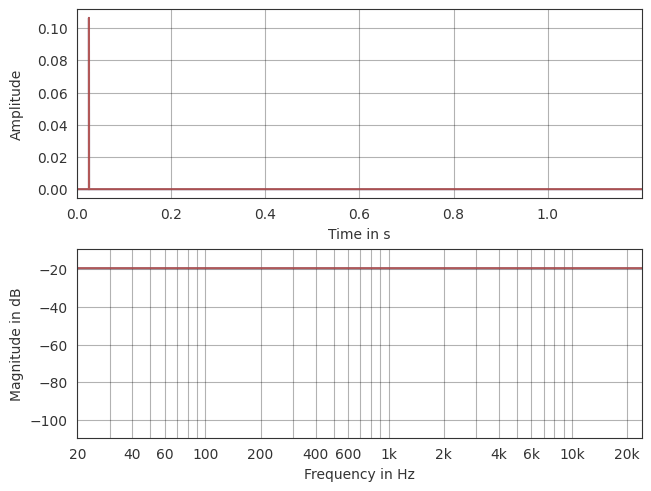

In [126]:
axs = pf.plot.time_freq(arr[i]["lower_anchor"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

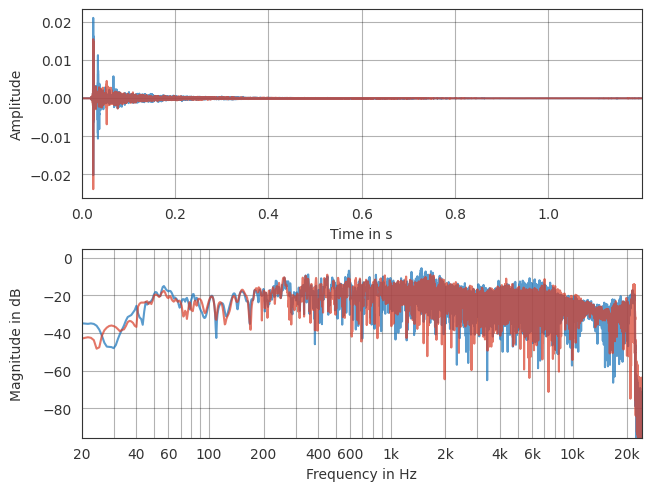

In [127]:
pf.plot.time_freq(arr[i]["reference"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

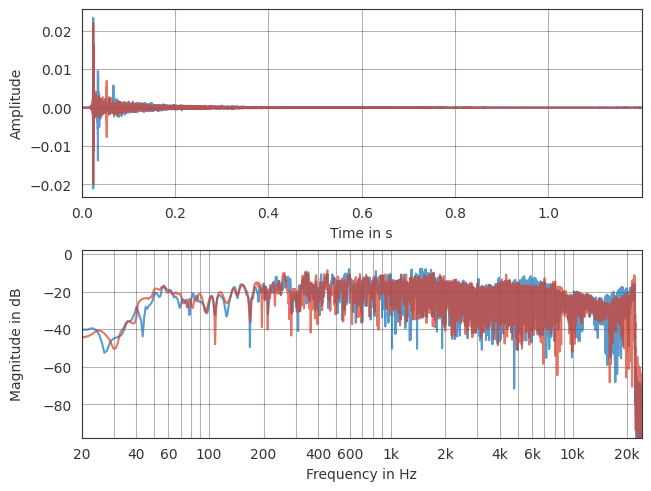

In [128]:
pf.plot.time_freq(arr[i]["nonextrapolating"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

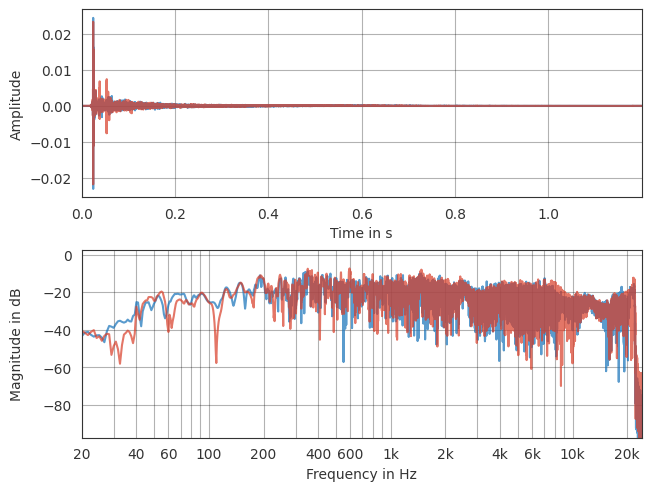

In [129]:
pf.plot.time_freq(arr[i]["good"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

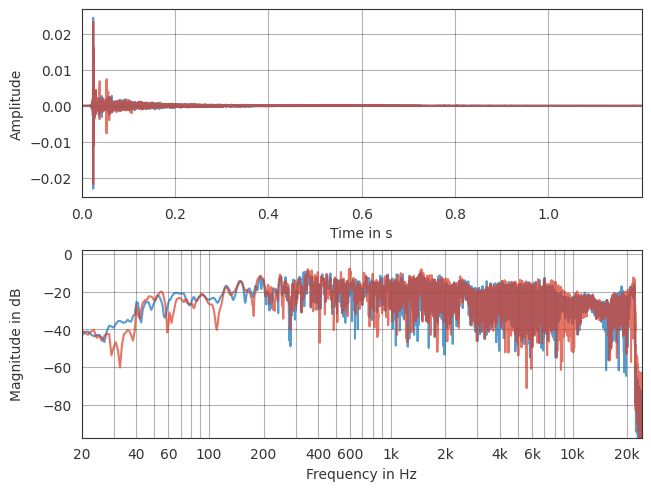

In [130]:
pf.plot.time_freq(arr[i]["good_filtered"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

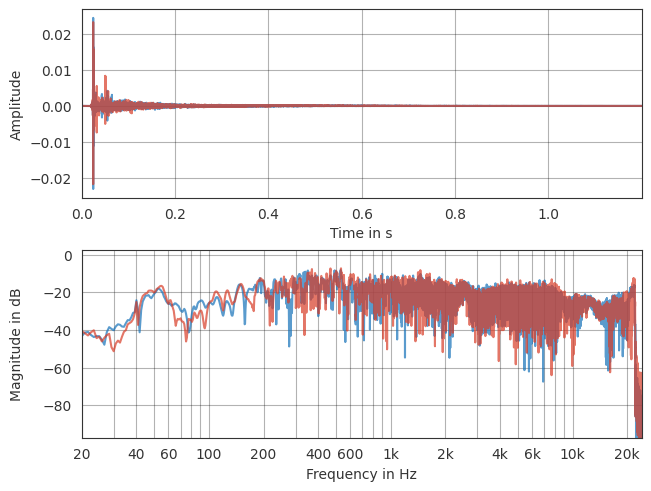

In [53]:
pf.plot.time_freq(arr[i]["mid_anchor"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

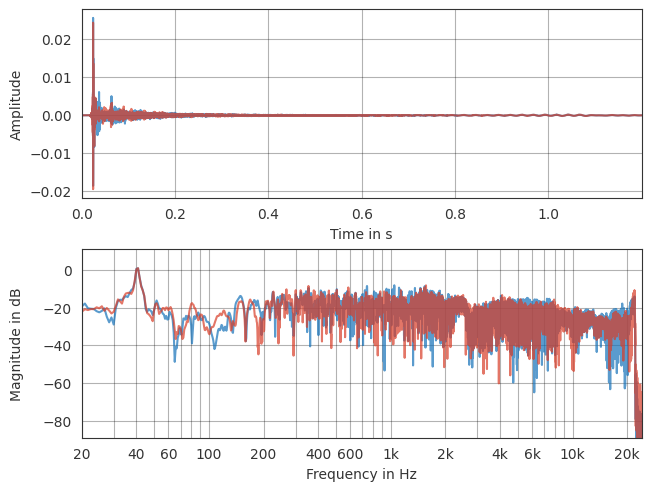

In [77]:
pf.plot.time_freq(arr[i]["bad"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

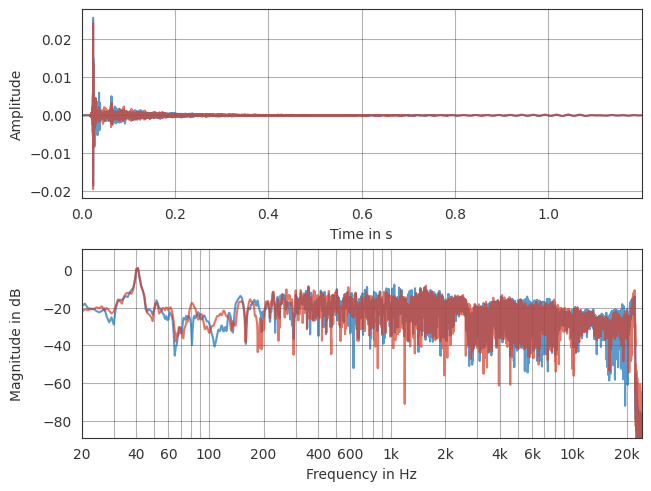

In [78]:
pf.plot.time_freq(arr[i]["bad_filtered"], alpha=.7)

(0.0, 0.1)

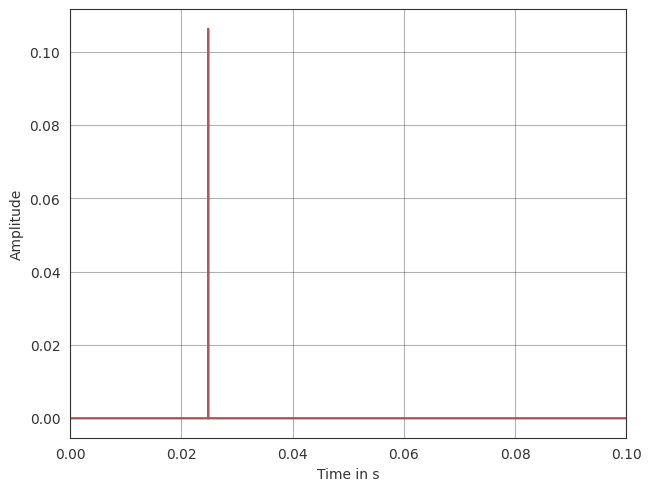

In [54]:
pf.plot.time(arr[i]["lower_anchor"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

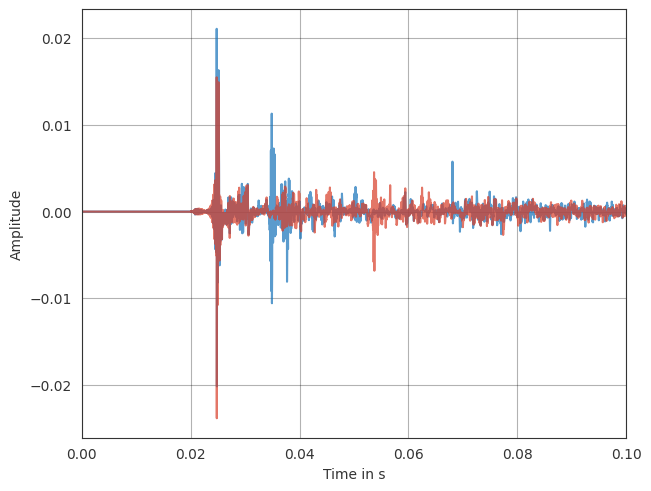

In [55]:
pf.plot.time(arr[i]["reference"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

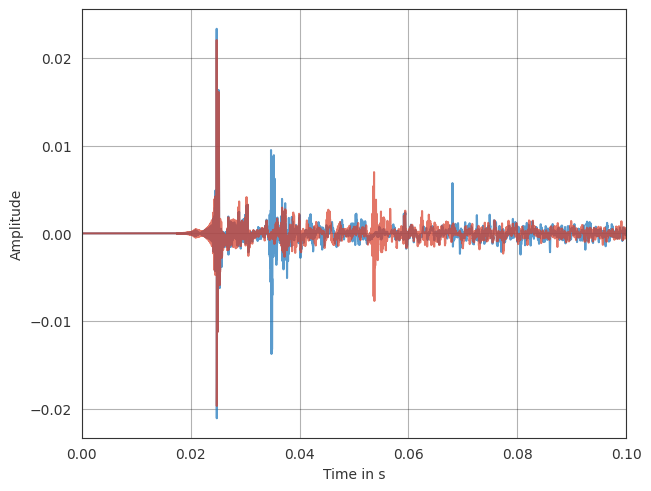

In [56]:
pf.plot.time(arr[i]["nonextrapolating"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

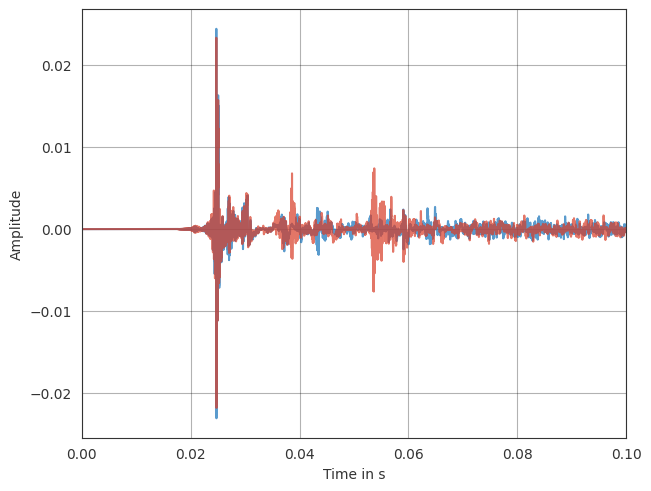

In [57]:
pf.plot.time(arr[i]["good"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

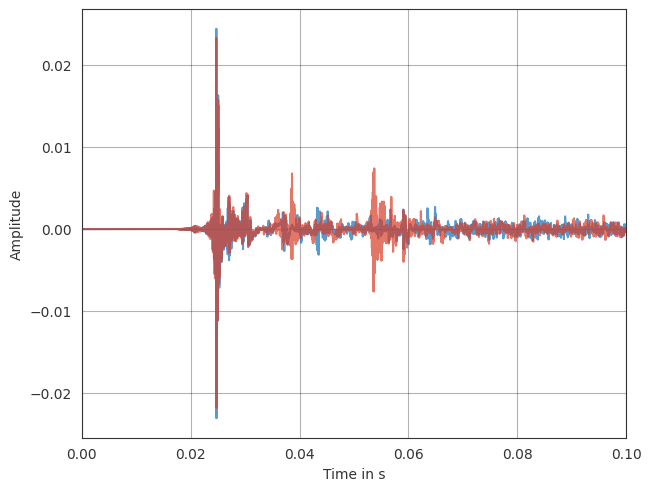

In [69]:
pf.plot.time(arr[i]["good_filtered"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

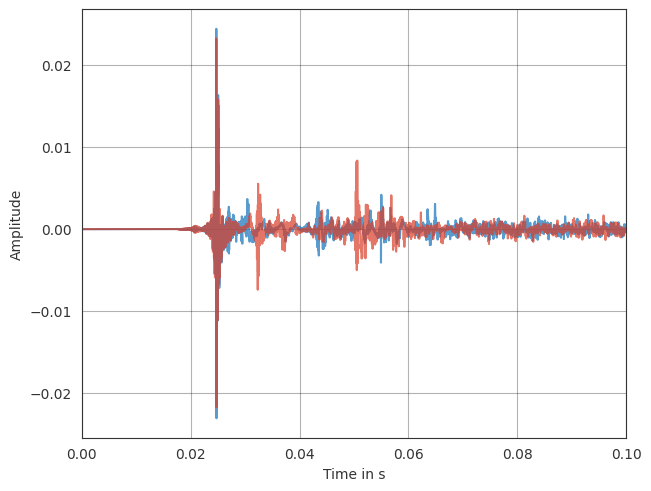

In [70]:
pf.plot.time(arr[i]["mid_anchor"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

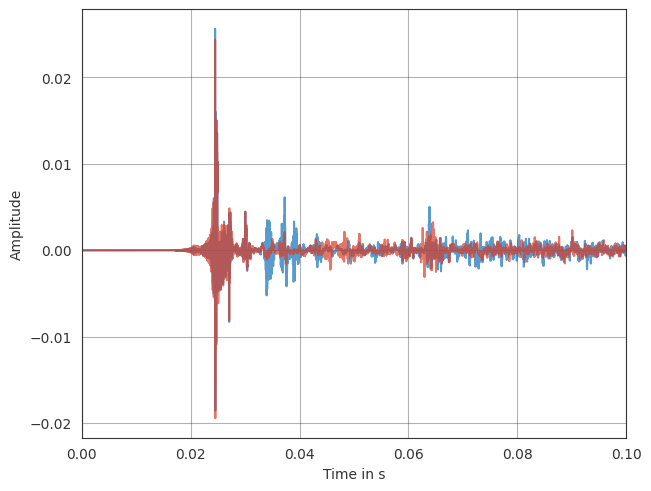

In [79]:
pf.plot.time(arr[i]["bad"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

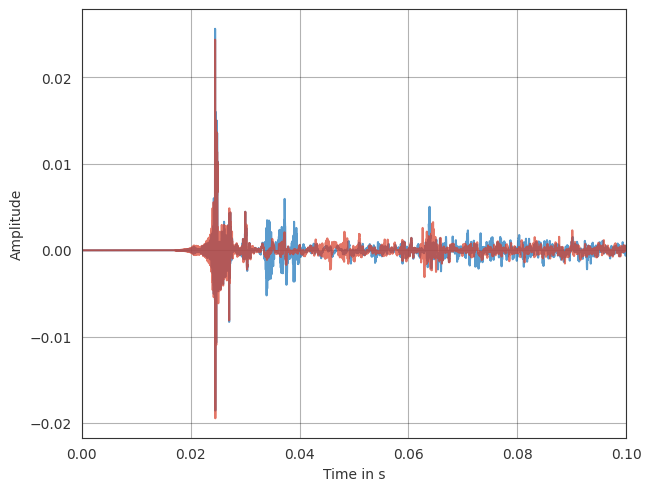

In [80]:
pf.plot.time(arr[i]["bad_filtered"], alpha=.7)
xlim(0, .1)

# i = 1

In [131]:
i = 1
df[i]

index,to_listener,to_source,room,from_listener_good,from_source_good,from_listener_bad,from_source_bad,az,az_idx
u32,str,i32,str,str,i32,str,i32,i32,u32
1,"""3.0X_2.0Y""",3,"""HL06W""","""3.0X_2.0Y""",2,"""3.0X_2.0Y""",4,-120,2


array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

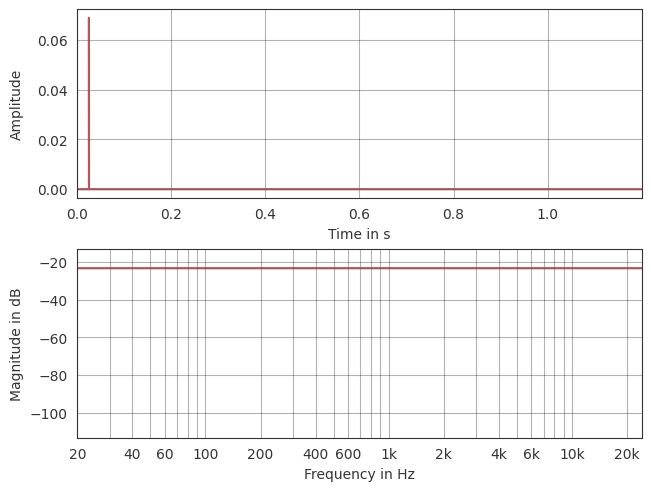

In [132]:
axs = pf.plot.time_freq(arr[i]["lower_anchor"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

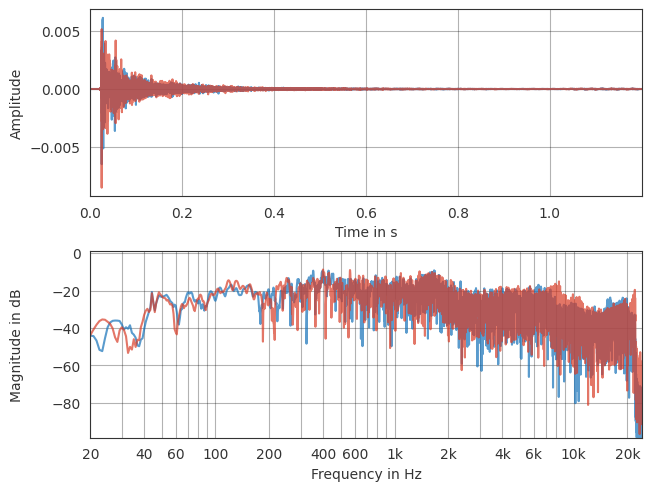

In [133]:
pf.plot.time_freq(arr[i]["reference"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

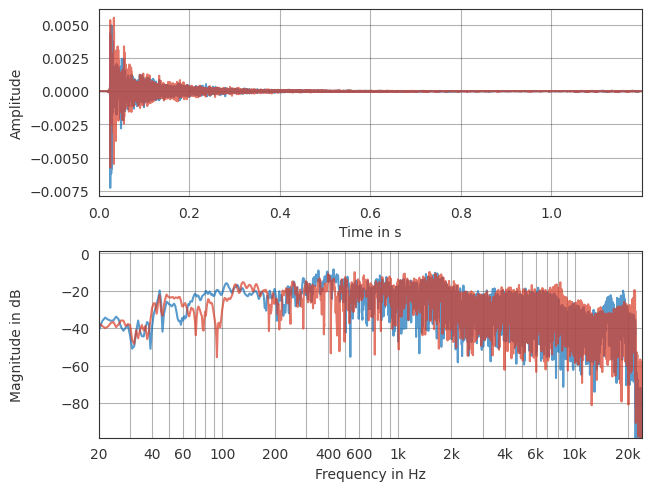

In [134]:
pf.plot.time_freq(arr[i]["nonextrapolating"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

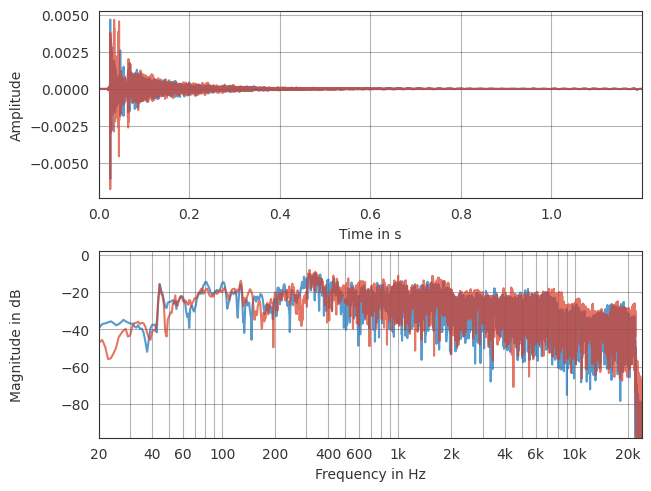

In [135]:
pf.plot.time_freq(arr[i]["good"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

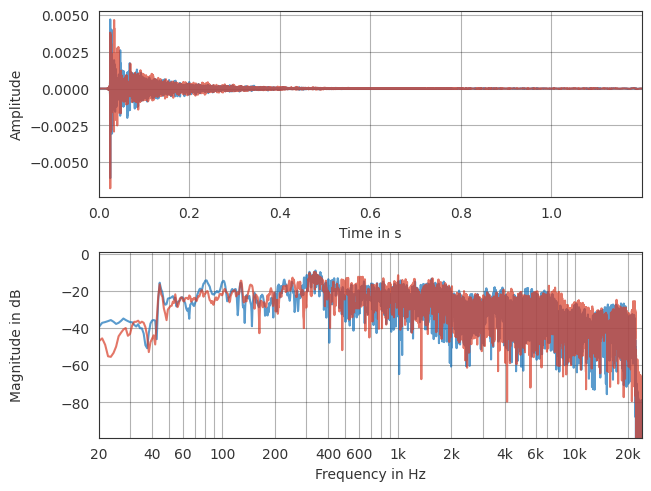

In [136]:
pf.plot.time_freq(arr[i]["good_filtered"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

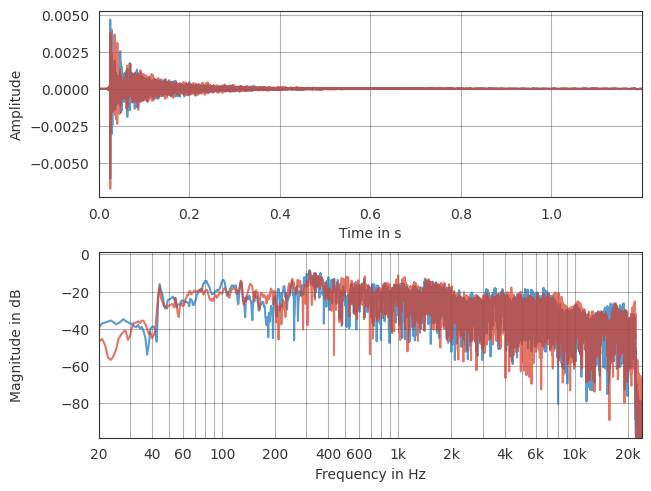

In [137]:
pf.plot.time_freq(arr[i]["mid_anchor"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

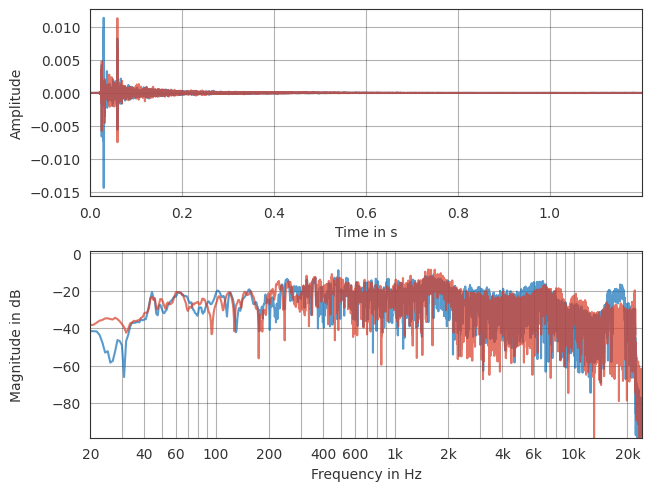

In [138]:
pf.plot.time_freq(arr[i]["bad"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

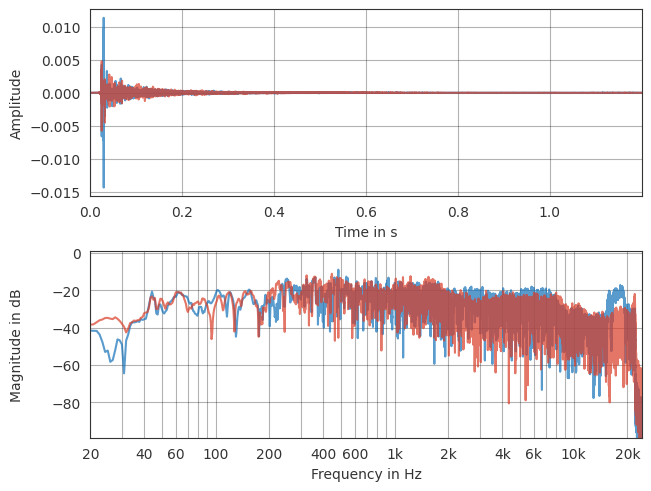

In [139]:
pf.plot.time_freq(arr[i]["bad_filtered"], alpha=.7)

(0.0, 0.1)

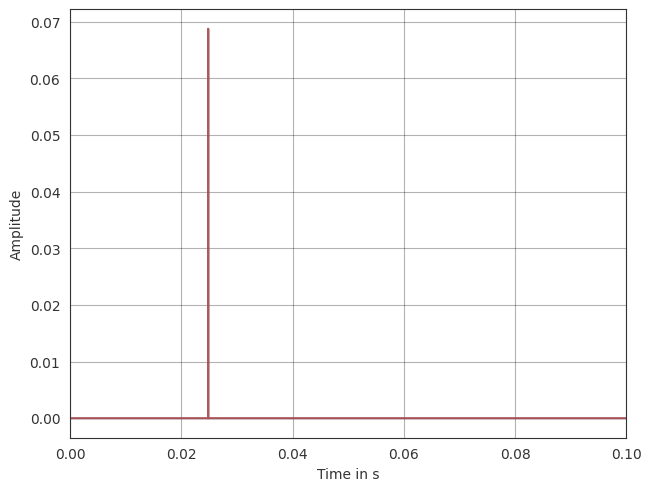

In [140]:
pf.plot.time(arr[i]["lower_anchor"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

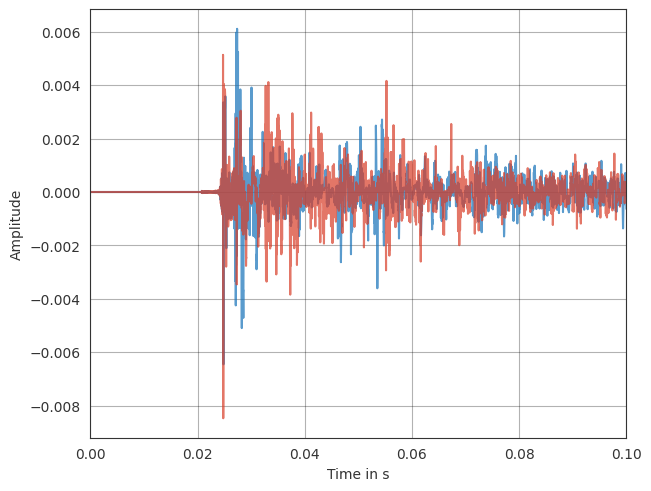

In [141]:
pf.plot.time(arr[i]["reference"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

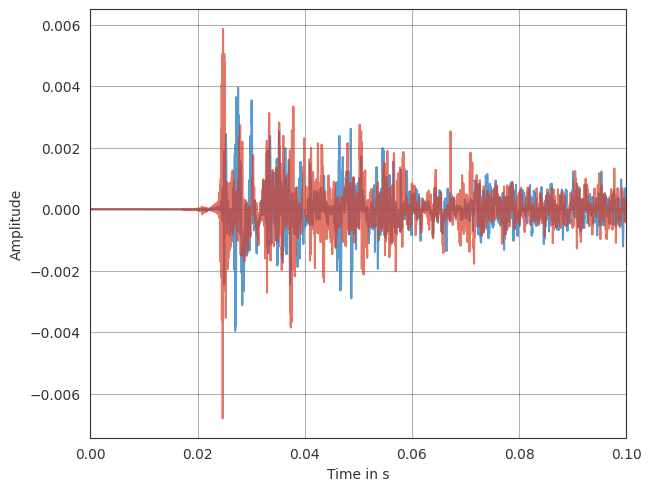

In [98]:
pf.plot.time(arr[i]["nonextrapolating"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

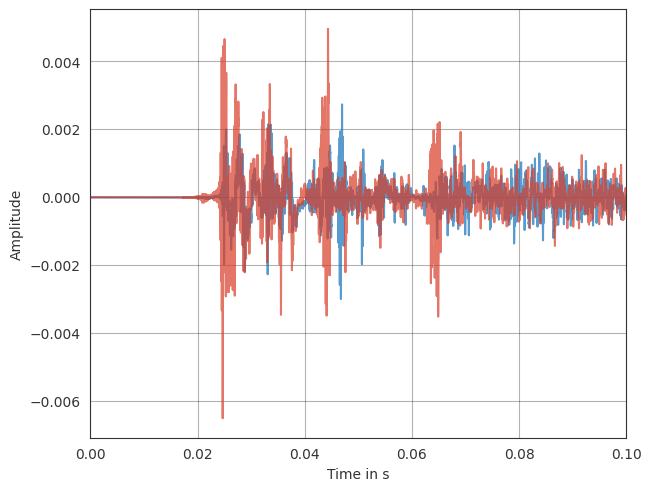

In [99]:
pf.plot.time(arr[i]["good"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

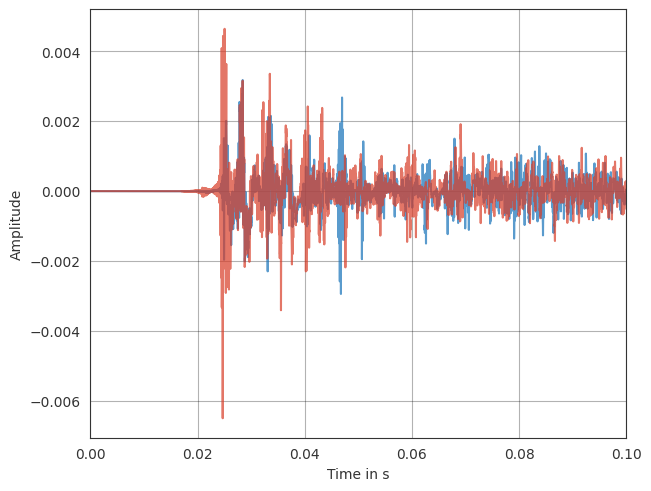

In [100]:
pf.plot.time(arr[i]["good_filtered"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

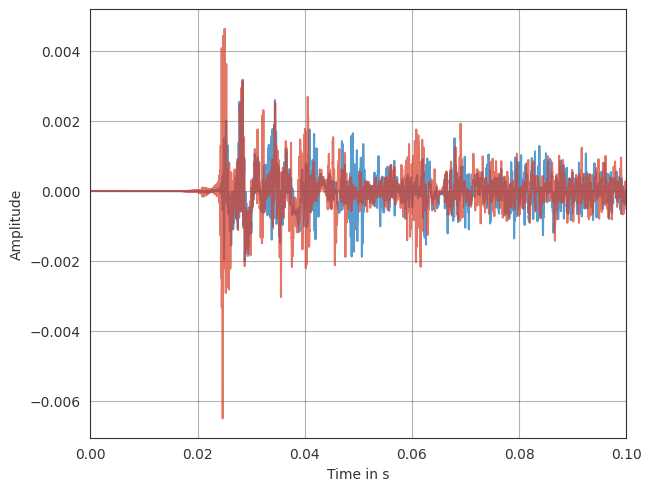

In [101]:
pf.plot.time(arr[i]["mid_anchor"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

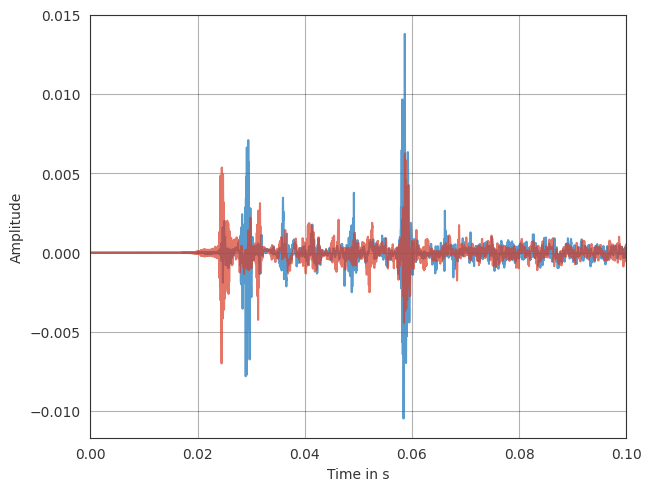

In [102]:
pf.plot.time(arr[i]["bad"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

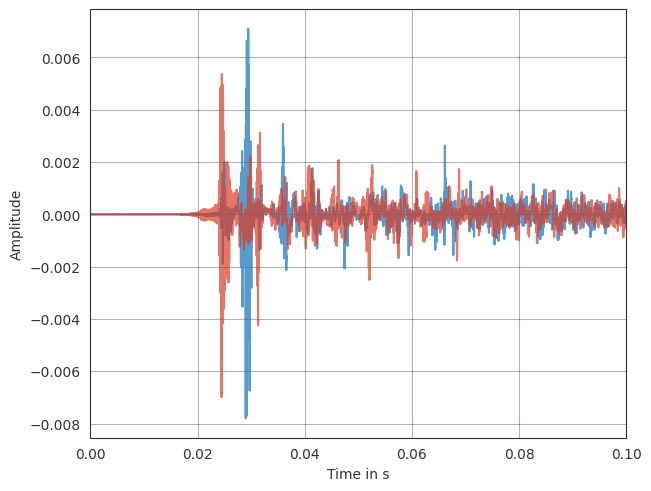

In [103]:
pf.plot.time(arr[i]["bad_filtered"], alpha=.7)
xlim(0, .1)

# i = 16

In [182]:
i = 16
df[i]

index,to_listener,to_source,room,from_listener_good,from_source_good,from_listener_bad,from_source_bad,az,az_idx
u32,str,i32,str,str,i32,str,i32,i32,u32
16,"""-1.75X_-3.0Y""",4,"""HL05W""","""3.0X_2.0Y""",0,"""0.0X_0.0Y""",3,90,9


array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

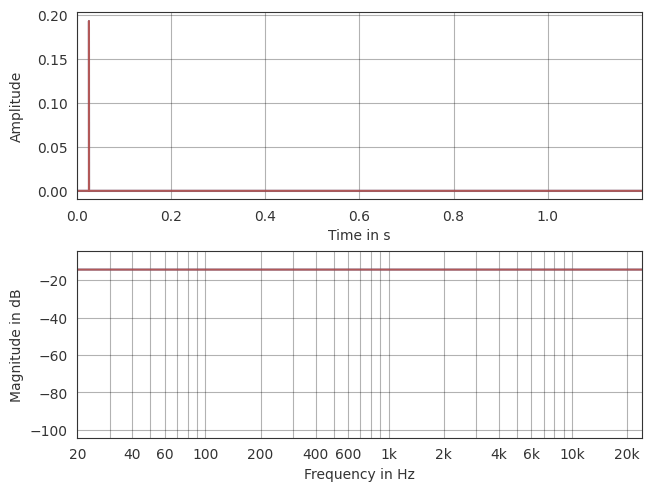

In [183]:
axs = pf.plot.time_freq(arr[i]["lower_anchor"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

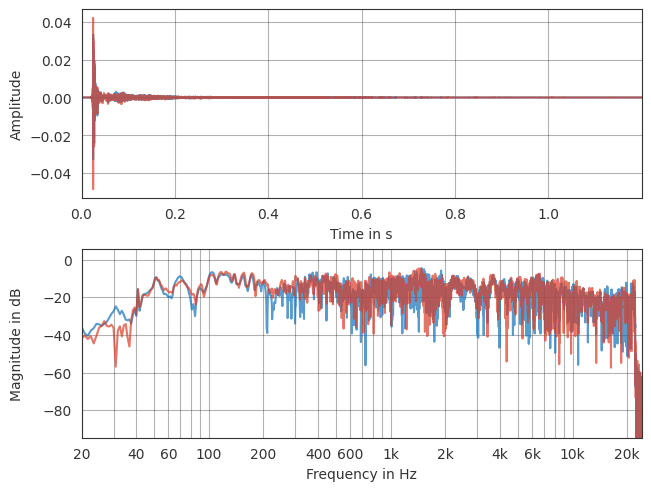

In [184]:
pf.plot.time_freq(arr[i]["reference"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

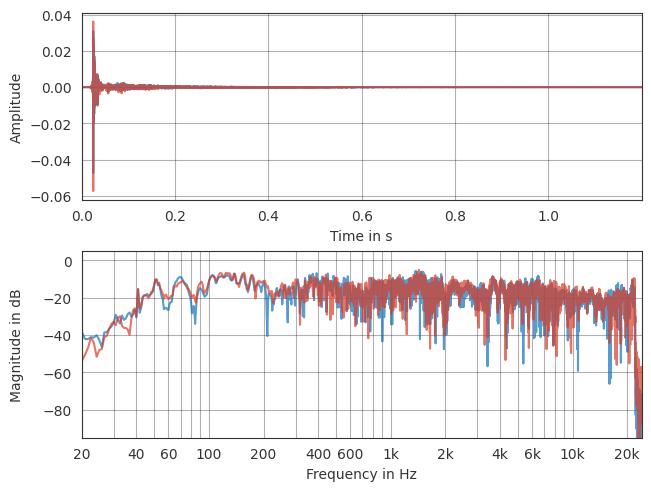

In [185]:
pf.plot.time_freq(arr[i]["nonextrapolating"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

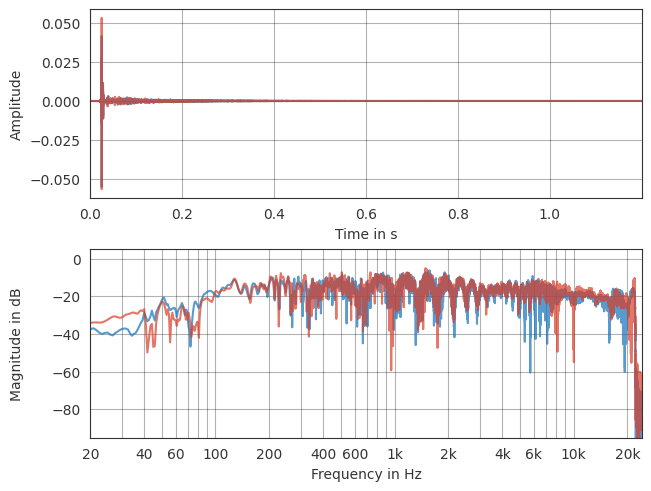

In [186]:
pf.plot.time_freq(arr[i]["good"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

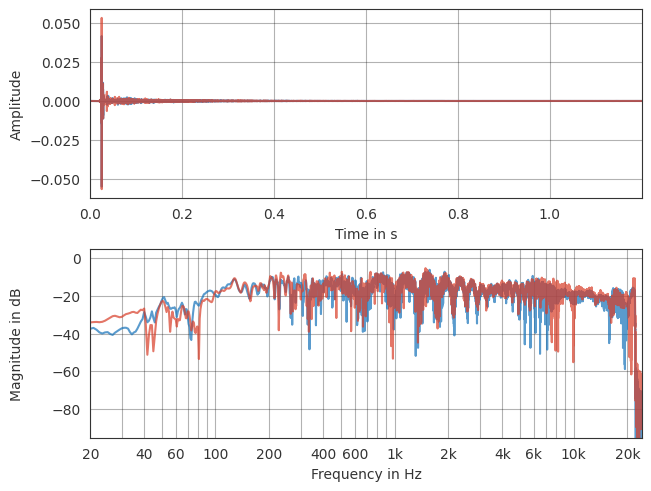

In [187]:
pf.plot.time_freq(arr[i]["good_filtered"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

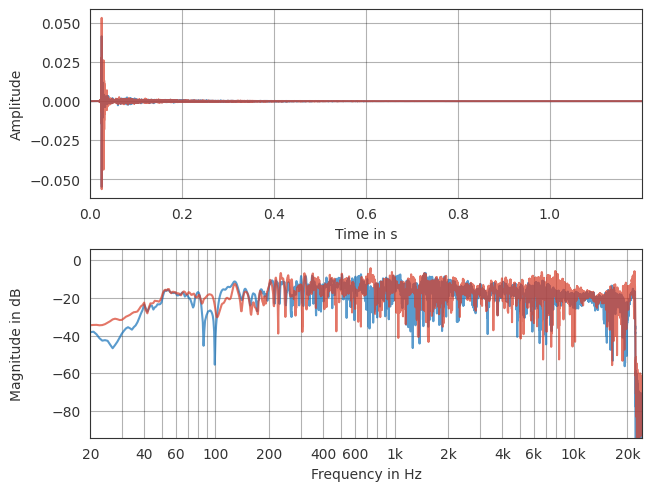

In [188]:
pf.plot.time_freq(arr[i]["mid_anchor"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

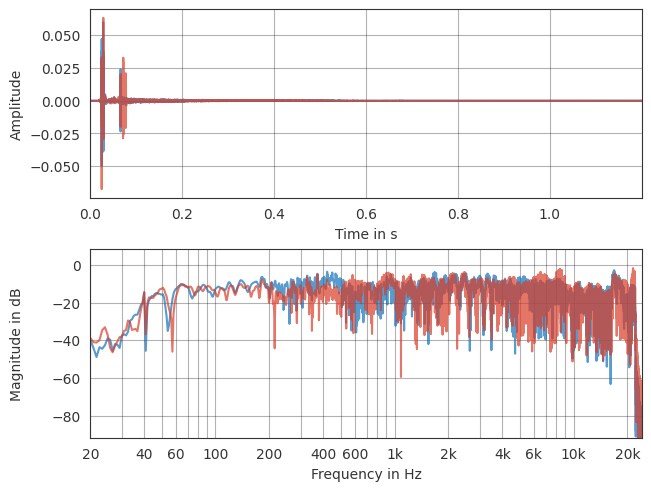

In [189]:
pf.plot.time_freq(arr[i]["bad"], alpha=.7)

array([<Axes: xlabel='Time in s', ylabel='Amplitude'>,
       <Axes: xlabel='Frequency in Hz', ylabel='Magnitude in dB'>],
      dtype=object)

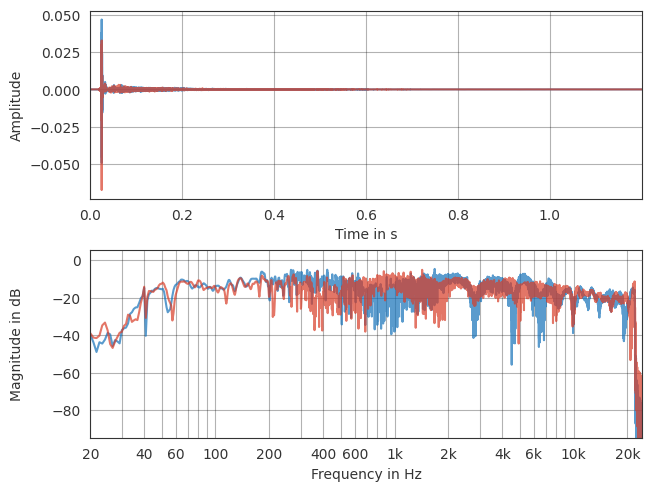

In [190]:
pf.plot.time_freq(arr[i]["bad_filtered"], alpha=.7)

(0.0, 0.1)

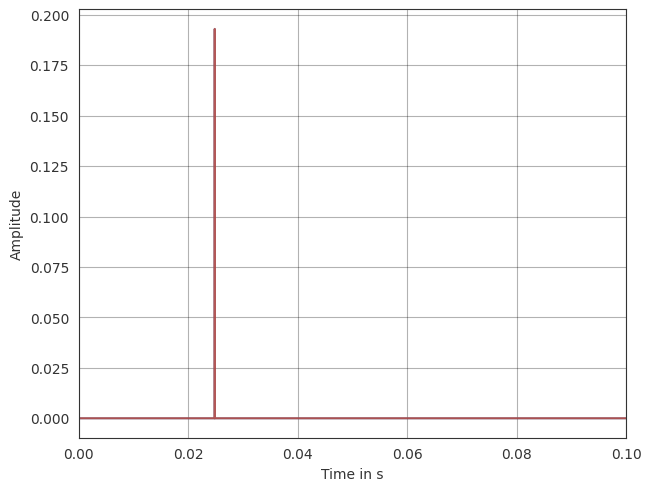

In [191]:
pf.plot.time(arr[i]["lower_anchor"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

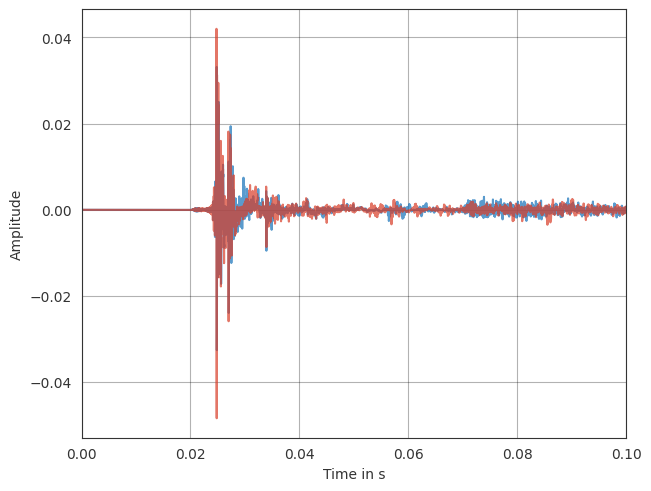

In [192]:
pf.plot.time(arr[i]["reference"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

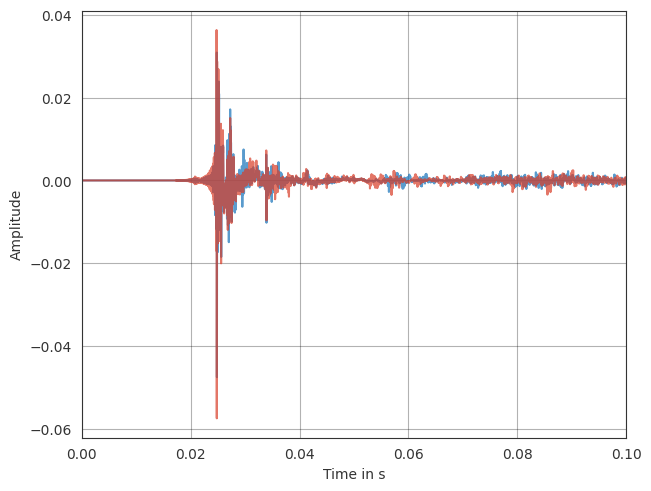

In [193]:
pf.plot.time(arr[i]["nonextrapolating"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

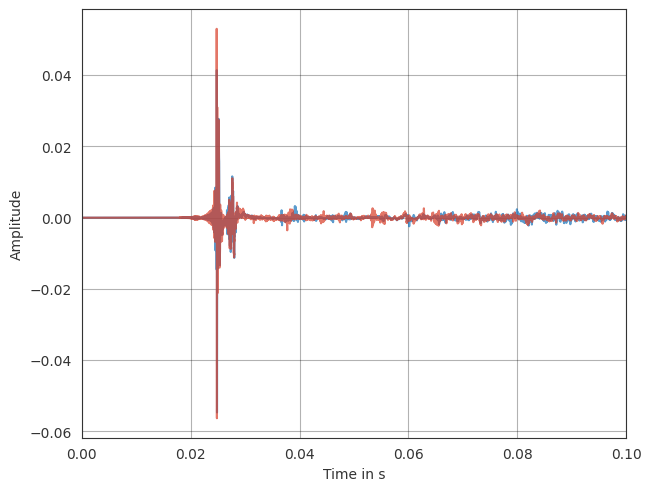

In [194]:
pf.plot.time(arr[i]["good"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

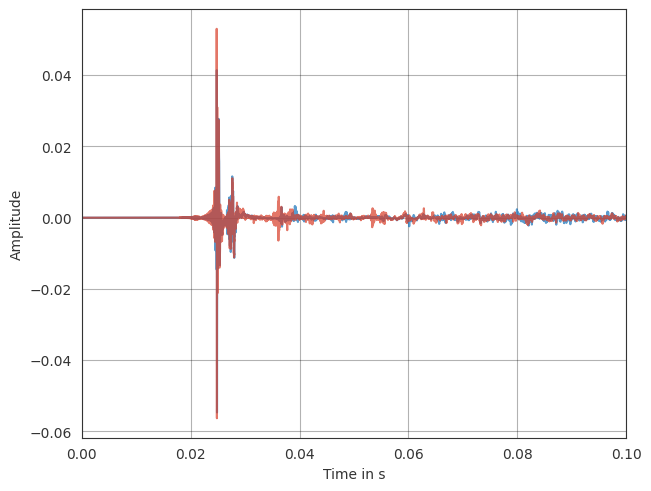

In [195]:
pf.plot.time(arr[i]["good_filtered"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

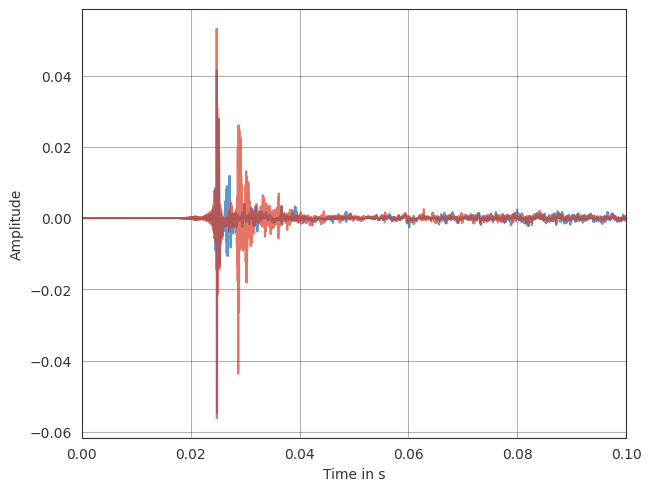

In [196]:
pf.plot.time(arr[i]["mid_anchor"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

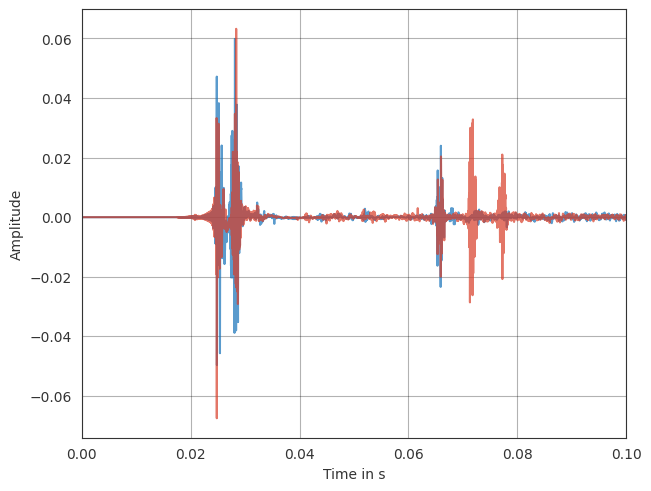

In [197]:
pf.plot.time(arr[i]["bad"], alpha=.7)
xlim(0, .1)

(0.0, 0.1)

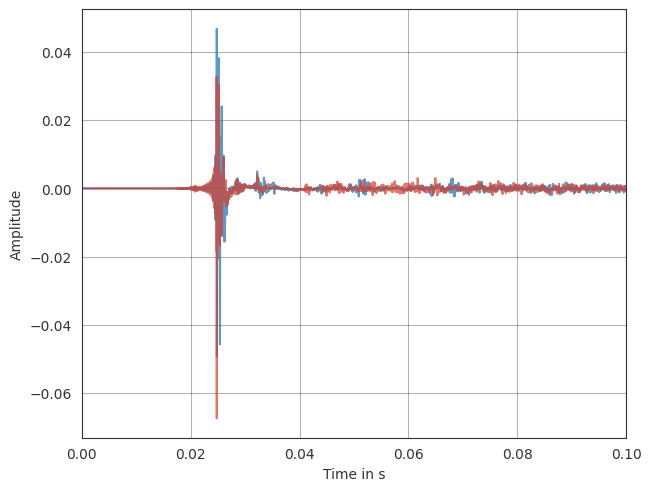

In [198]:
pf.plot.time(arr[i]["bad_filtered"], alpha=.7)
xlim(0, .1)

# Listen

In [176]:
import sounddevice

In [177]:
dry_sound = pf.dsp.resample(pf.io.read_audio("../data/external/example_sounds/WelcomeToVA.wav"), a.fs)

time domain energy Signal:
(1,) channels with 168000 samples @ 48000.0 Hz sampling rate and none FFT normalization

In [178]:
result_neg120 = pf.dsp.convolve(arr[i]["reference"], dry_sound).time.T

array([[-9.86864911e-19, -4.93432455e-18],
       [-8.88178420e-18,  1.97372982e-18],
       [ 2.96059473e-18,  2.96059473e-18],
       ...,
       [-1.97372982e-18,  4.93432455e-19],
       [ 4.44089210e-18, -2.96059473e-18],
       [ 4.44089210e-18, -2.46716228e-18]])

In [179]:
#sounddevice.play(result_neg120, a.fs)